In [ ]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Enhance your data preprocessing to extract temporal features
def preprocess_with_time_features(file_path):
    df = pd.read_csv(file_path)
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['date'], keep='last')
    
    # Handle missing values
    df.replace(to_replace='-', value=np.nan, inplace=True)
    df.snow_depth_cm = df.snow_depth_cm.replace(to_replace='-1', value='0')
    
    # Convert to numeric
    df['avg_temp_c'] = pd.to_numeric(df['avg_temp_c'], errors='coerce')
    df['snow_depth_cm'] = pd.to_numeric(df['snow_depth_cm'], errors='coerce')
    df['uv_index'] = pd.to_numeric(df['uv_index'], errors='coerce')
    
    # Convert date string to datetime object
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Drop rows with missing target values
    df = df.dropna(subset=['snow_depth_cm'])
    
    return df

# Step 2: Combine datasets with time features
datasets = [
    'data_by_location/Messila_data.csv',
    'data_by_location/Purnu_data.csv',
    'data_by_location/Ruunarinteet_data.csv',
    'data_by_location/Kasurila_data.csv'
]

all_data = []
for dataset in datasets:
    try:
        df = preprocess_with_time_features(dataset)
        all_data.append(df)
    except Exception as e:
        print(f"Error processing {dataset}: {e}")

combined_df = pd.concat(all_data)

# Step 3: Create features including time components
X = combined_df[['avg_temp_c', 'uv_index', 'cloud_cover_rate', 'month', 'day_of_year']]
y = combined_df['snow_depth_cm']

# Handle any missing values
X = X.fillna(X.mean())

# Step 4: Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Model MAE: {mae}")

# Save model
joblib.dump(model, 'snow_depth_time_model.joblib')

# Step 5: Function to predict future snow depth based on historical trends
def predict_future_snow_depth(model, start_date, days=365, location_data=None):
    """
    Predict snow depth for future dates based on historical trends
    
    Parameters:
    - model: Trained model
    - start_date: Start date for predictions (string YYYY-MM-DD or datetime)
    - days: Number of days to predict forward
    - location_data: Sample data from a location to use as base values
    
    Returns:
    - DataFrame with dates and predicted snow depths
    """
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Create date range
    future_dates = [start_date + timedelta(days=i) for i in range(days)]
    future_df = pd.DataFrame({'date': future_dates})
    
    # Extract time features
    future_df['year'] = future_df['date'].dt.year
    future_df['month'] = future_df['date'].dt.month
    future_df['day'] = future_df['date'].dt.day
    future_df['day_of_year'] = future_df['date'].dt.dayofyear
    
    # Generate weather features based on historical averages by day of year and trends
    if location_data is not None:
        # Calculate historical trends based on the historical data
        trends = {
            'avg_temp_c': location_data.groupby('year')['avg_temp_c'].mean().diff().mean(),  # average yearly temp change
            'uv_index': location_data.groupby('year')['uv_index'].mean().diff().mean(),    # average yearly UV change
            'cloud_cover_rate': location_data.groupby('year')['cloud_cover_rate'].mean().diff().mean()  # cloud cover trend
        }
        
        # Group location data by day of year and get averages
        daily_averages = location_data.groupby('day_of_year').agg({
            'avg_temp_c': 'mean',
            'uv_index': 'mean',
            'cloud_cover_rate': 'mean'
        }).reset_index()
        
        # Merge with future dates
        future_df = future_df.merge(daily_averages, on='day_of_year', how='left')
        
        # For days not in historical data, use nearest day
        future_df = future_df.fillna(method='ffill').fillna(method='bfill')
        
        # Adjust features based on the historical trends
        for year in future_df['year'].unique():
            year_diff = year - location_data['year'].min()  # Calculate how many years into the future
            future_df.loc[future_df['year'] == year, 'avg_temp_c'] += trends['avg_temp_c'] * year_diff
            future_df.loc[future_df['year'] == year, 'uv_index'] += trends['uv_index'] * year_diff
            future_df.loc[future_df['year'] == year, 'cloud_cover_rate'] += trends['cloud_cover_rate'] * year_diff

    else:
        # If no location data is provided, use seasonal patterns and trends
        future_df['month_rad'] = future_df['month'] * 2 * np.pi / 12
        future_df['avg_temp_c'] = -10 * np.cos(future_df['month_rad']) + 5
        future_df['uv_index'] = 3 * np.cos((future_df['month_rad'] + np.pi)) + 3
        future_df['cloud_cover_rate'] = 0.5 + 0.2 * np.sin(future_df['month_rad'])
        
        trends = {'avg_temp_c': 0.1, 'uv_index': 0.01, 'cloud_cover_rate': 0.001}  # Example trends for demonstration
        
        future_df['avg_temp_c'] += (future_df['year'] - future_df['year'].min()) * trends['avg_temp_c']
        future_df['uv_index'] += (future_df['year'] - future_df['year'].min()) * trends['uv_index']
        future_df['cloud_cover_rate'] += (future_df['year'] - future_df['year'].min()) * trends['cloud_cover_rate']

    # Prepare features for prediction in the same format as training data
    X_future = future_df[['avg_temp_c', 'uv_index', 'cloud_cover_rate', 'month', 'day_of_year']]
    
    # Make predictions
    future_df['predicted_snow_depth'] = model.predict(X_future)
    future_df['predicted_snow_depth'] = future_df['predicted_snow_depth'].clip(lower=0)
    
    return future_df[['date', 'predicted_snow_depth', 'avg_temp_c', 'uv_index', 'cloud_cover_rate']]

# Example usage:
# 1. Load a sample location dataset for reference weather patterns
sample_location = preprocess_with_time_features('data_by_location/Messila_data.csv')

# 2. Load the trained model
trained_model = joblib.load('snow_depth_time_model.joblib')

# 3. Predict snow depth for next year starting from a specific date
start_prediction_date = '2025-01-01'
future_predictions = predict_future_snow_depth(
    model=trained_model,
    start_date=start_prediction_date,
    days=15 * 365,  # You can adjust the number of days as per your requirement
    location_data=sample_location
)

print(f"Predictions for snow depth from {start_prediction_date}:")
print(future_predictions.head())

# 4. Save predictions to CSV
future_predictions.to_csv('snow_depth_predictions_2025.csv', index=False)
print("Future predictions saved to snow_depth_predictions_2025.csv")

#

Model MAE: 4.818181093186445


C:\Users\marik\AppData\Local\Temp\ipykernel_27996\1159303245.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df = future_df.fillna(method='ffill').fillna(method='bfill')


Predictions for snow depth from 2025-01-01:
        date  predicted_snow_depth  avg_temp_c  uv_index  cloud_cover_rate
0 2025-01-01             18.721136  -13.755455  -0.05635          8.415301
1 2025-01-02             19.985235  -15.479265  -0.05135          7.783722
2 2025-01-03             19.206913  -16.155455  -0.05135          9.310038
3 2025-01-04             18.665486  -16.136407  -0.05135          8.836353
4 2025-01-05             20.870690  -17.484027  -0.04135          7.783722
Future predictions saved to snow_depth_predictions_2025.csv


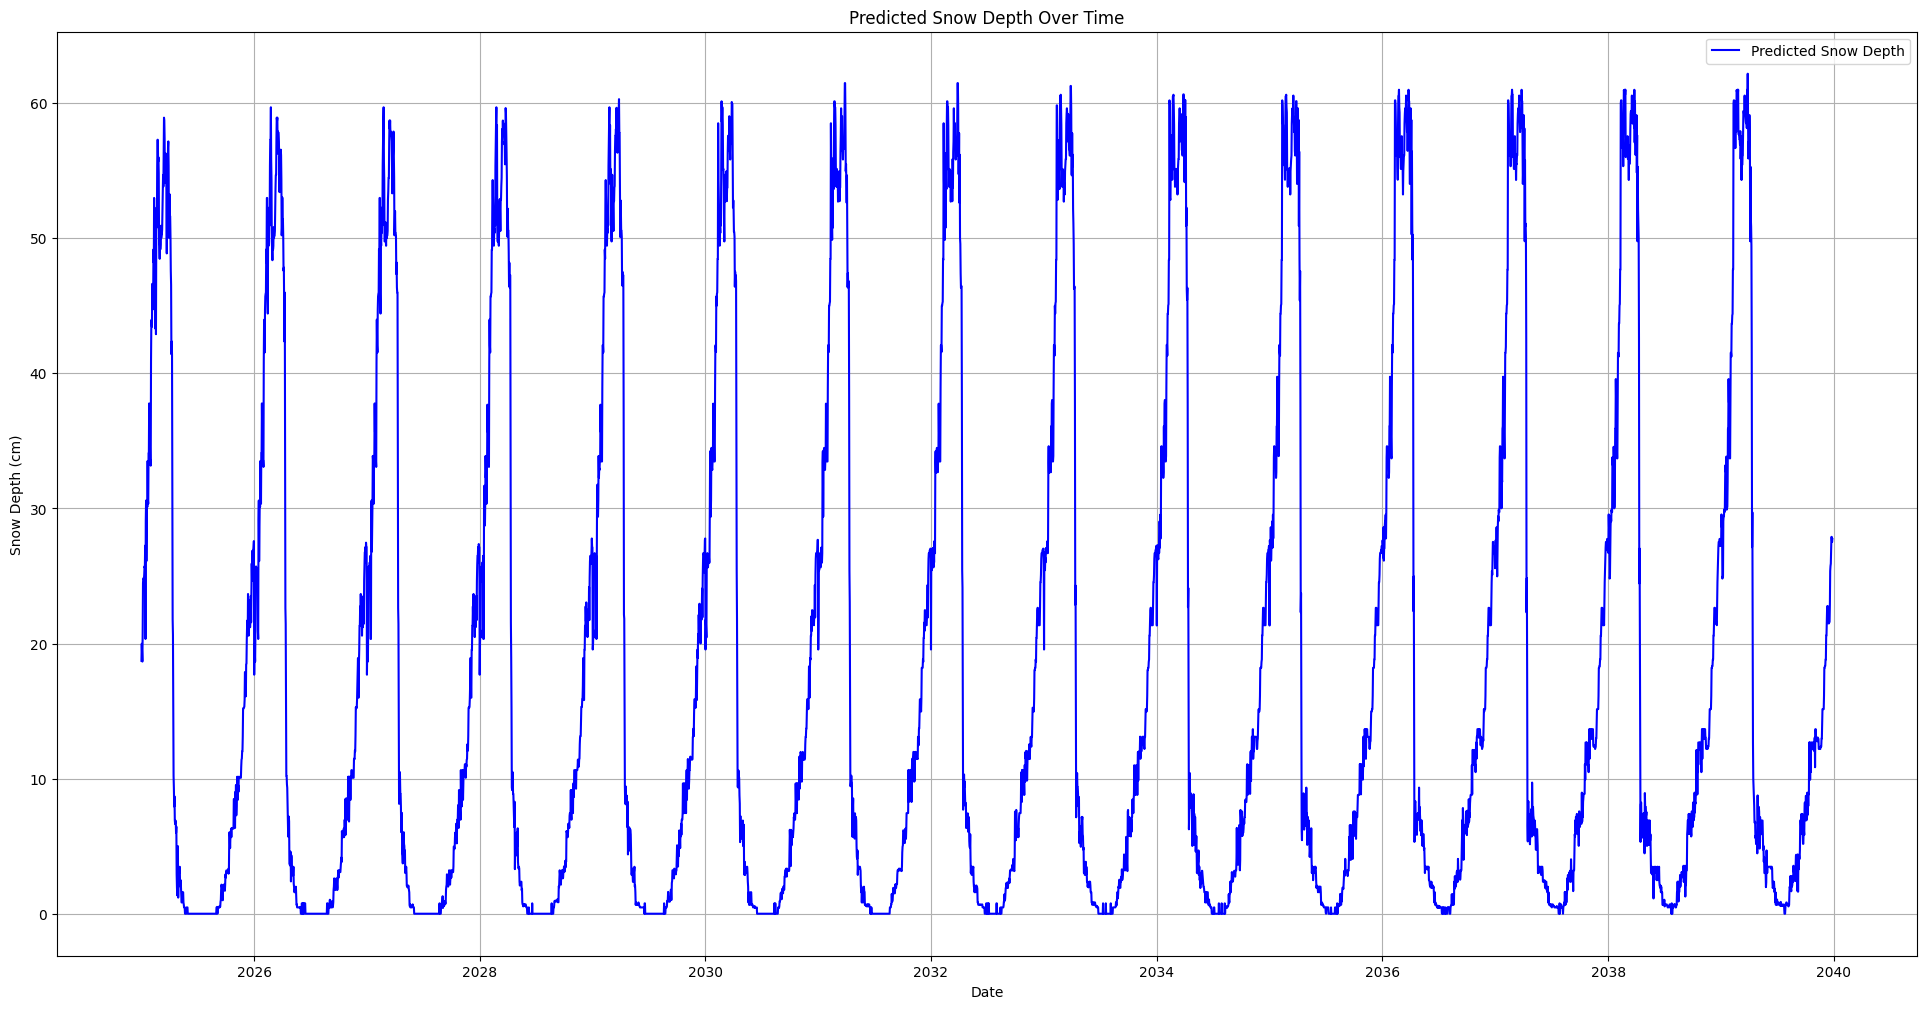

In [3]:
import matplotlib.pyplot as plt

# Plot the predictions
plt.figure(figsize=(24, 12))
plt.plot(future_predictions['date'], future_predictions['predicted_snow_depth'], label='Predicted Snow Depth', color='blue')

# Formatting
plt.xlabel("Date")
plt.ylabel("Snow Depth (cm)")
plt.title("Predicted Snow Depth Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()